In [25]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline
from collections import Counter
import torch.optim.lr_scheduler as lr_scheduler
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputClassifier

Load dataset and tokenize the processed comment texts

In [26]:
# Load the dataset
file_path = "cleaned_train.csv"
df = pd.read_csv(file_path)

# Tokenize and build vocabulary
def tokenize(texts): 
    vocab = Counter(word for text in texts for word in text.split())
    word_to_idx = {word: idx + 1 for idx, word in enumerate(vocab)}  # Reserve 0 for padding
    return [[word_to_idx[word] for word in text.split()] for text in texts], word_to_idx

# Tokenize the processed_comment_text
print("Tokenizing text...")
df['processed_comment_text'] = df['processed_comment_text'].fillna("unknown") # remove null values
df['cleaned_comment_text'] = df['cleaned_comment_text'].fillna("unknown") # remove null values
tokenized_texts, word_to_idx = tokenize(df['processed_comment_text'])

# Pad sequences to ensure equal length
max_seq_length = 100  # Adjust this based on your dataset or task
padded_texts = [seq[:max_seq_length] + [0] * max(0, max_seq_length - len(seq)) for seq in tokenized_texts]

# Add tokenized and padded texts back to the dataframe
df['tokenized_comment_text'] = padded_texts

print("Tokenization and padding complete!")

Tokenizing text...
Tokenization and padding complete!


Create train and evaluate logistic regression for each label

In [35]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(train_data['processed_comment_text'])
X_test_tfidf = vectorizer.transform(test_data['processed_comment_text'])

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
metrics_lr = {}
models_lr = {}

# Train a Logistic Regression model for each label
for label in labels:
    y_train = train_data[label]
    y_test = test_data[label]

    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train_tfidf, y_train)

    y_pred = model.predict(X_test_tfidf)

    metrics_lr[label] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred)
    }

    models_lr[label] = model # save models for LIME

# Display metrics for the baseline model
metrics_df_lr = pd.DataFrame([
    {'Class': label, **metrics_lr[label]} for label in labels
])
print("\nBaseline Logistic Regression Metrics:")
print(metrics_df_lr)


Baseline Logistic Regression Metrics:
           Class  accuracy        f1  precision    recall
0          toxic  0.957888  0.740240   0.904155  0.626636
1   severe_toxic  0.990694  0.366738   0.581081  0.267913
2        obscene  0.977283  0.751286   0.912500  0.638484
3         threat  0.997807  0.186047   0.666667  0.108108
4         insult  0.970359  0.644628   0.818702  0.531599
5  identity_hate  0.991759  0.283379   0.712329  0.176871


LIME explanation of logistic regression for each label

Comment: Carioca RFA 

Thanks for your support on my request for adminship.

The final outcome was (31/4/1), so I am now an administrator. If you have any comments or concerns on my actions as an administrator, please let me know. Thank you!
Predicted flag for toxic: 0
True flag for toxic: 0


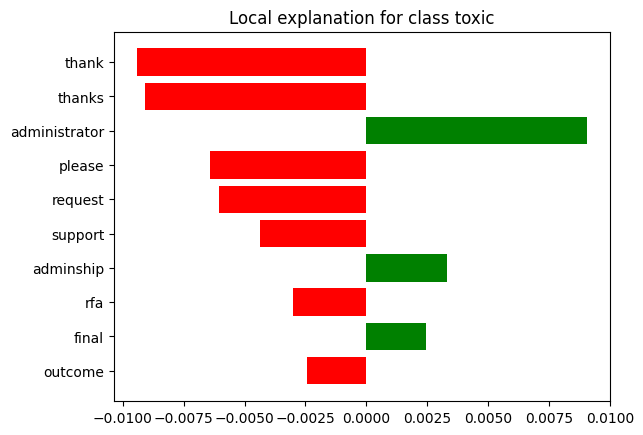

Comment: no worries 

We will use another account, and will not stop until wikipedia stops pushing the evil, sin filled gay agenda
Predicted flag for toxic: 1
True flag for toxic: 1


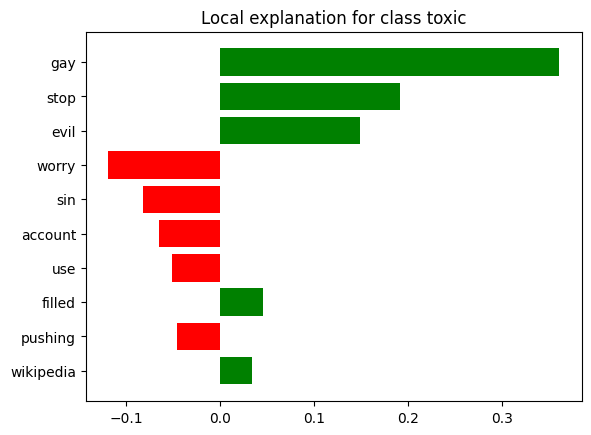

Comment: you fucking piece of shit
Predicted flag for severe_toxic: 1
True flag for severe_toxic: 1


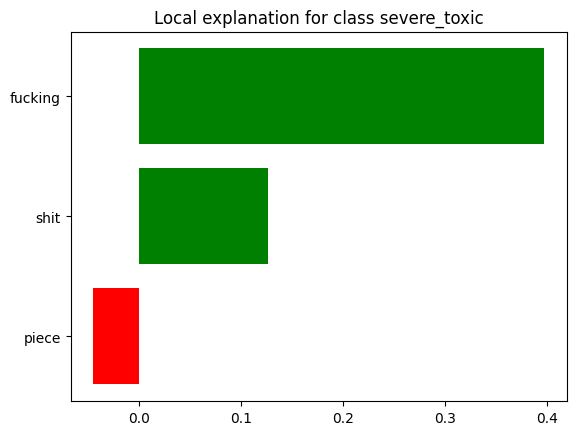

Comment: Renzoy16 ! Shut The Fuck Up
Predicted flag for obscene: 1
True flag for obscene: 1


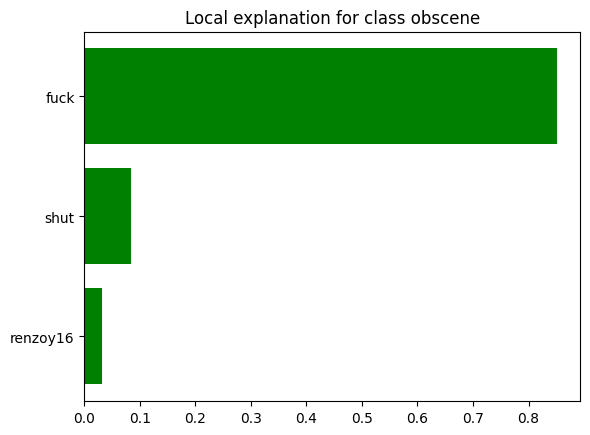

Comment: FUCK BILLCJ AND KILL BILLCJ BECAUSE I HATE HIS BIG FAT FUCK 

KILL BILLCJ!! KILL BILLCJ! KILL BILLCJS ASS! KILL HIS BIG FAT FUCK!! KILL HIS ASS! KILL BILLCJ! FUCK BILLCJ! KILL HIS ASS! KILL BILLCJ!!! KILL BILLCJ!! I HATE HIM! KILL BILLCJ AND AVENGE TOUGHHEAD!!! KILL HIS ASS!!!
Predicted flag for threat: 1
True flag for threat: 1


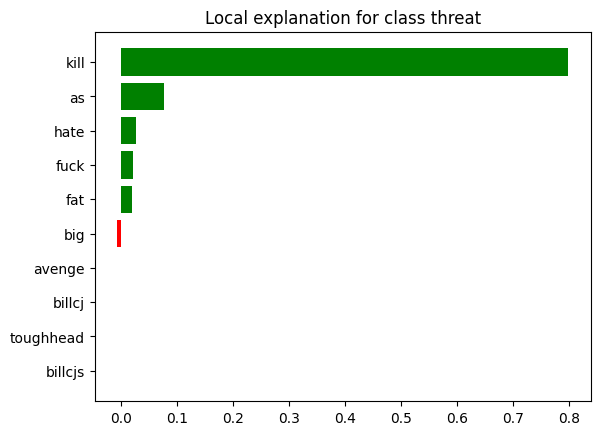

Comment: Suck my dikkkkk ==
Suck my dikkkkk Gogo Gogo giving blowjobs on demand
Predicted flag for insult: 1
True flag for insult: 1


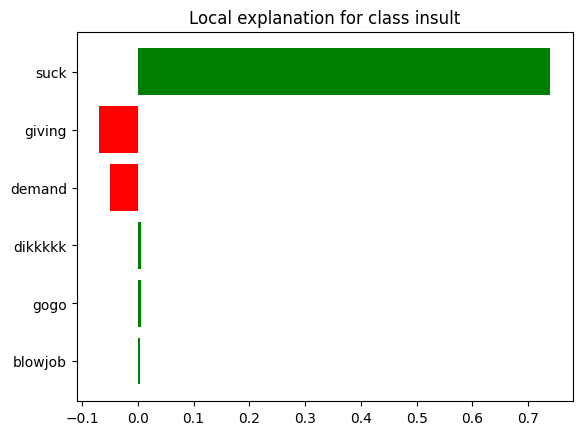

Comment: your gay douche like gay porno ahaghagagagaa
Predicted flag for identity_hate: 1
True flag for identity_hate: 1


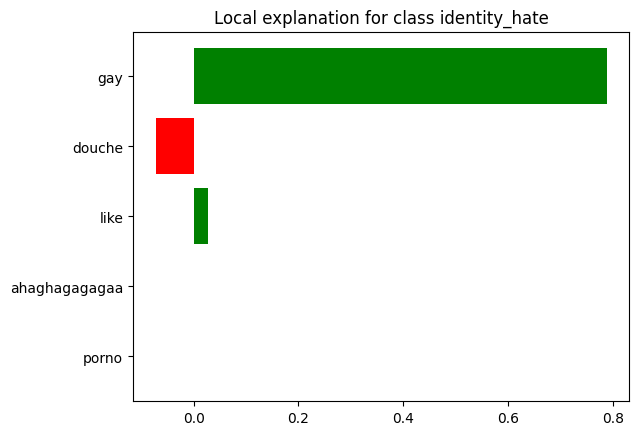

In [48]:
# get explanations for baseline model

# positive comment explained for non-toxic flag
pipeline = make_pipeline(vectorizer, models_lr['toxic']) # create pipeline for LIME
explainer = LimeTextExplainer(class_names=['non_toxic', 'toxic'])  # explainer class

idx = np.where(models_lr['toxic'].predict(X_test_tfidf) == 0)[0][1] # select comment

explaination = explainer.explain_instance(test_data['processed_comment_text'].iloc[idx], pipeline.predict_proba) # explaination instance

print(f"Comment: {test_data['comment_text'].iloc[idx]}")
print(f"Predicted flag for toxic: {(pipeline.predict_proba([test_data['processed_comment_text'].iloc[idx]])[0][1] > 0.5).astype(int)}")
print(f"True flag for toxic: {test_data['toxic'].iloc[idx]}")

fig = explaination.as_pyplot_figure()
plt.show()

# negative comments by labels
select = [0, 1, 0, 1, 1, 0]
select_idx = 0

for label in labels:
    pipeline = make_pipeline(vectorizer, models_lr[label]) # create pipeline for LIME
    explainer = LimeTextExplainer(class_names=['non_'+label, label])  # explainer class

    idx = models_lr[label].predict(X_test_tfidf).nonzero()[0][select[select_idx]] # select comment
    select_idx += 1

    explaination = explainer.explain_instance(test_data['processed_comment_text'].iloc[idx], pipeline.predict_proba) # explaination instance

    print(f"Comment: {test_data['comment_text'].iloc[idx]}")
    print(f"Predicted flag for {label}: {(pipeline.predict_proba([test_data['processed_comment_text'].iloc[idx]])[0][1] > 0.5).astype(int)}")
    print(f"True flag for {label}: {test_data[label].iloc[idx]}")

    fig = explaination.as_pyplot_figure()
    plt.show()

Create train and evaluate logistic regression for multiple outputs

In [29]:
tfidf_vectorizer = TfidfVectorizer()
train_tfidf = tfidf_vectorizer.fit_transform(train_data['processed_comment_text'])
test_tfidf = tfidf_vectorizer.transform(test_data['processed_comment_text'])

# MultiOutput Logistic Regression classifier
lr_model = LogisticRegression(max_iter=1000)
multioutput_model = MultiOutputClassifier(lr_model)
multioutput_model.fit(train_tfidf, train_data[labels])

# Predictions
preds = multioutput_model.predict(test_tfidf)

# Overall metrics
accuracy = accuracy_score(test_data[labels].values, preds)
f1_macro = f1_score(test_data[labels].values, preds, average='macro')
f1_micro = f1_score(test_data[labels].values, preds, average='micro')
precision_macro = precision_score(test_data[labels].values, preds, average='macro')
precision_micro = precision_score(test_data[labels].values, preds, average='micro')
recall_macro = recall_score(test_data[labels].values, preds, average='macro')
recall_micro = recall_score(test_data[labels].values, preds, average='micro')

print("Overall Evaluation Metrics on Test Set:")
print(f"  Accuracy:         {accuracy:.4f}")
print(f"  Macro-Averaged F1: {f1_macro:.4f}")
print(f"  Micro-Averaged F1: {f1_micro:.4f}")
print(f"  Macro-Averaged Precision: {precision_macro:.4f}")
print(f"  Micro-Averaged Precision: {precision_micro:.4f}")
print(f"  Macro-Averaged Recall: {recall_macro:.4f}")
print(f"  Micro-Averaged Recall: {recall_micro:.4f}")

Overall Evaluation Metrics on Test Set:
  Accuracy:         0.9179
  Macro-Averaged F1: 0.4844
  Micro-Averaged F1: 0.6745
  Macro-Averaged Precision: 0.7343
  Micro-Averaged Precision: 0.8727
  Macro-Averaged Recall: 0.3806
  Micro-Averaged Recall: 0.5496


Split dataset into training and validation sets and create data loaders

In [30]:
texts = df['tokenized_comment_text'].tolist()
labels = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values.tolist()

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Define PyTorch Dataset class
class ToxicCommentDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Create DataLoaders
train_loader = DataLoader(ToxicCommentDataset(train_texts, train_labels), batch_size=64, shuffle=True)
val_loader = DataLoader(ToxicCommentDataset(val_texts, val_labels), batch_size=64, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


Define RNN models

In [31]:
class IndependentProbabilitiesModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.dropout(output)
        return torch.sigmoid(self.fc(output[:, -1, :]))  # Independent probabilities

class JointProbabilitiesModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.dropout(output)
        return torch.softmax(self.fc(output[:, -1, :]), dim=-1)  # Joint probabilities

Create model instances with appropriate parameters

In [32]:
# Parameters
vocab_size = len(word_to_idx) + 1  # Vocabulary size + 1 for padding
embed_dim = 128
hidden_dim = 256
num_layers = 2
output_dim_independent = len(labels[0])  # Number of labels (6)
output_dim_joint = 2 ** len(labels[0])  # Number of joint label configurations (64)

# Initialize models
independent_model = IndependentProbabilitiesModel(vocab_size, embed_dim, hidden_dim, output_dim_independent, num_layers)
joint_model = JointProbabilitiesModel(vocab_size, embed_dim, hidden_dim, output_dim_joint, num_layers)

# Move models to device
device = "cuda" if torch.cuda.is_available() else "cpu"
independent_model.to(device)
joint_model.to(device)

print("Models initialized and moved to device:", device)

Models initialized and moved to device: cuda


Define training functions

In [ ]:
# Define training function for the independent model
def train_independent_model(model, data_loader, val_loader, optimizer, criterion, device, epoch):
    model.train()
    losses = []
    total_loss = 0
    print(f"\nTraining Independent Probabilities Model - Epoch {epoch+1}")
    for batch_idx, (texts, labels) in enumerate(data_loader, start=1):
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        optimizer.step()
        total_loss += loss.item()
        losses.append(loss.item())

        # Print progress for every 10 batches
        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}/{len(data_loader)}, Loss: {loss.item():.4f}")

    model.eval()
    val_losses = []
    with torch.no_grad():
        for texts, labels in val_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())

    return total_loss / len(data_loader), losses, val_losses


# Define training function for the joint model
def train_joint_model(model, data_loader, val_loader, optimizer, criterion, device, epoch):
    model.train()
    train_losses = []
    total_loss = 0
    print(f"\nTraining Joint Probability Model - Epoch {epoch+1}")
    for batch_idx, (texts, labels) in enumerate(data_loader, start=1):
        texts, labels = texts.to(device), labels.to(device)
        labels = torch.argmax(labels, dim=1)  # Convert multi-label to single index
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        optimizer.step()
        total_loss += loss.item()
        train_losses.append(loss.item())

        # Print progress for every 10 batches
        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}/{len(data_loader)}, Loss: {loss.item():.4f}")

    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_idx, (texts, labels) in enumerate(val_loader, start=1):
            texts, labels = texts.to(device), labels.to(device)
            labels = torch.argmax(labels, dim=1)  # Convert multi-label to single index
            outputs = model(texts)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())

    return total_loss / len(data_loader), train_losses, val_losses

Training the RNN models

In [ ]:
# Optimizers and Loss Functions
independent_optimizer = optim.Adam(independent_model.parameters(), lr=0.001)
joint_optimizer = optim.Adam(joint_model.parameters(), lr=0.001)

epochs = 10
independent_lr = lr_scheduler.LinearLR(independent_optimizer, 1.0, 0.5, epochs)
joint_lr = lr_scheduler.LinearLR(joint_optimizer, 1.0, 0.8, epochs)

ind_train_loss_hist = []
ind_val_loss_hist = []
joint_train_loss_hist = []
joint_val_loss_hist = []

bce_loss = nn.BCELoss()  # Binary Cross-Entropy Loss for independent model
cross_entropy_loss = nn.CrossEntropyLoss()  # Cross-Entropy Loss for joint model

# Training loop with clear separation
for epoch in range(epochs):
    print("=" * 50)
    print(f"Starting Epoch {epoch+1} of Training\n")
    
    # Train Independent Model
    ind_loss, ind_train_loss_chunck, ind_val_loss_chunk = train_independent_model(independent_model, train_loader, val_loader, independent_optimizer, bce_loss, device, epoch)
    independent_lr.step()
    print(f"\nEpoch {epoch+1} - Independent Model Training Complete. Loss: {ind_loss:.4f}")
    
    # Train Joint Model
    joint_loss, joint_train_loss_chunk, joint_val_loss_chunk = train_joint_model(joint_model, train_loader, val_loader, joint_optimizer, cross_entropy_loss, device, epoch)
    joint_lr.step()
    print(f"\nEpoch {epoch+1} - Joint Model Training Complete. Loss: {joint_loss:.4f}")
    
    ind_train_loss_hist.extend(ind_train_loss_chunck)
    ind_val_loss_hist.extend(ind_val_loss_chunk)
    joint_train_loss_hist.extend(joint_train_loss_chunk)
    joint_val_loss_hist.extend(joint_val_loss_chunk)

    print("=" * 50)

Plot training data

In [ ]:
plt.plot(np.arange(len(ind_train_loss_hist)), ind_train_loss_hist)
plt.xlabel('Train Iteration')
plt.ylabel('Train Loss')
plt.title('Independent Probabilities Model')
plt.show()

In [ ]:
plt.plot(np.arange(len(ind_val_loss_hist)), ind_val_loss_hist)
plt.xlabel('Validation Iteration')
plt.ylabel('Validation Loss')
plt.title('Independent Probabilities Model')
plt.show()

In [ ]:
plt.plot(np.arange(len(joint_train_loss_hist)), joint_train_loss_hist, color='green')
plt.xlabel('Train Iteration')
plt.ylabel('Train Loss')
plt.title('Joint Probabilities Model')
plt.show()

In [ ]:
plt.plot(np.arange(len(joint_val_loss_hist)), joint_val_loss_hist, color='green')
plt.xlabel('Validation Iteration')
plt.ylabel('Validation Loss')
plt.title('Joint Probabilities Model')
plt.show()

Number of model params

In [52]:
model_parameters_independent = filter(lambda p: p.requires_grad, independent_model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters_independent])
print("Number of trainable parameters in independent model:", params)

Number of trainable parameters in independent model: 30363910


In [53]:
model_parameters_joint = filter(lambda p: p.requires_grad, joint_model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters_joint])
print("Number of trainable parameters in joint model:", params)

Number of trainable parameters in joint model: 30378816


Compute evaluation metrics for the RNN models

In [24]:
# Function to compute evaluation metrics
def compute_metrics(model, data_loader, device, independent=True):
    model.eval()
    all_preds, all_labels = [], []
    print("\nEvaluating Model...")
    with torch.no_grad():
        for batch_idx, (texts, labels) in enumerate(data_loader, start=1):
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            if independent:
                preds = (outputs > 0.5).float()  # Binary predictions for independent model
            else:
                preds = torch.argmax(outputs, dim=1)
                preds = torch.eye(len(labels[0]), device=device)[preds]  # Convert to multi-label format
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

            # Progress log
            if batch_idx % 10 == 0:
                print(f"Processed {batch_idx}/{len(data_loader)} batches")

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    return {
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds, average='micro'),
        'precision': precision_score(all_labels, all_preds, average='micro'),
        'recall': recall_score(all_labels, all_preds, average='micro')
    }

# Compute and print metrics
ind_metrics = compute_metrics(independent_model, val_loader, device, independent=True)
print("\nIndependent Model Metrics:")
print(ind_metrics)

joint_metrics = compute_metrics(joint_model, val_loader, device, independent=False)
print("\nJoint Model Metrics:")
print(joint_metrics)


Evaluating Model...
Processed 10/499 batches
Processed 20/499 batches
Processed 30/499 batches
Processed 40/499 batches
Processed 50/499 batches
Processed 60/499 batches
Processed 70/499 batches
Processed 80/499 batches
Processed 90/499 batches
Processed 100/499 batches
Processed 110/499 batches
Processed 120/499 batches
Processed 130/499 batches
Processed 140/499 batches
Processed 150/499 batches
Processed 160/499 batches
Processed 170/499 batches
Processed 180/499 batches
Processed 190/499 batches
Processed 200/499 batches
Processed 210/499 batches
Processed 220/499 batches
Processed 230/499 batches
Processed 240/499 batches
Processed 250/499 batches
Processed 260/499 batches
Processed 270/499 batches
Processed 280/499 batches
Processed 290/499 batches
Processed 300/499 batches
Processed 310/499 batches
Processed 320/499 batches
Processed 330/499 batches
Processed 340/499 batches
Processed 350/499 batches
Processed 360/499 batches
Processed 370/499 batches
Processed 380/499 batches


LIME explainers for the RNN models

In [50]:
# define classifier function for LIME for independent model
def independent_classifier(texts):
    # tokenize and pad input text
    tokenized_texts = [[word_to_idx[word] for word in text.split()] for text in texts]
    max_seq_length = 100
    padded_texts = [seq[:max_seq_length] + [0] * max(0, max_seq_length - len(seq)) for seq in tokenized_texts]

    # get model outputs for input texts
    all_probs = []
    independent_model.eval()
    with torch.no_grad():
        for text in padded_texts:
            text = torch.tensor(text, dtype=torch.long).unsqueeze(0).to(device)
            outputs = independent_model(text)
            all_probs.append(outputs.cpu().numpy())

    return np.vstack(all_probs)

# create LIME Explainer object and labels dictionary
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
explainer = LimeTextExplainer(class_names=labels)
labels = {keys : idx for idx, keys in enumerate(labels)}

Explain independent model

Comment: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Predicted flags: [0 0 0 0 0 0]
True flags:
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 0, dtype: object


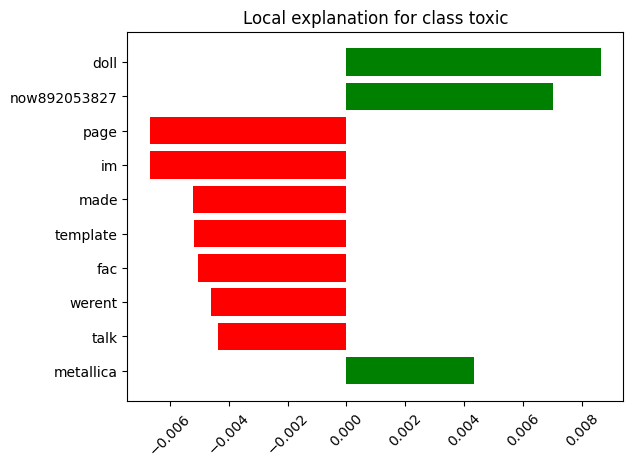

Comment: COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
Predicted flag for toxic: 1
True flag for toxic: 1


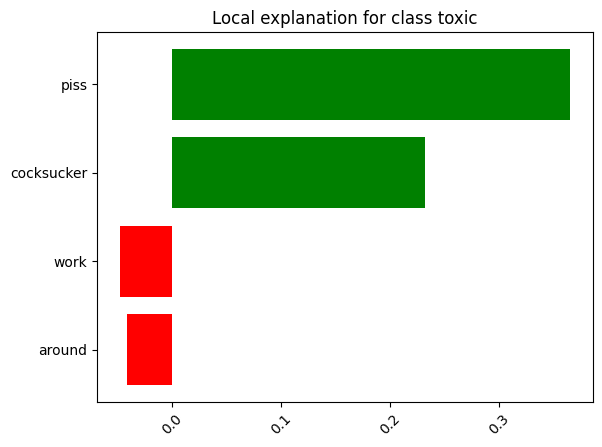

Comment: Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!
Predicted flag for severe_toxic: 1
True flag for severe_toxic: 1


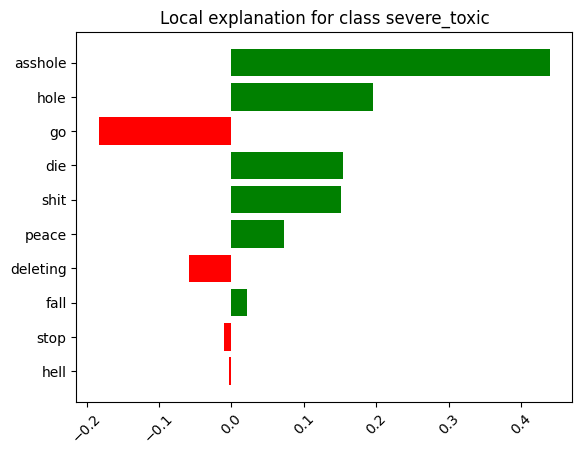

Comment: GET FUCKED UP. GET FUCKEEED UP.  GOT A DRINK THAT YOU CANT PUT DOWN???/ GET FUCK UP GET FUCKED UP.  I'M FUCKED UP RIGHT NOW!
Predicted flag for obscene: 1
True flag for obscene: 1


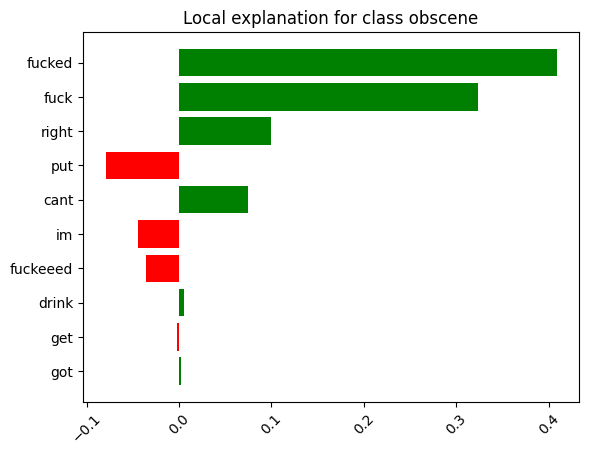

Comment: Hi! I am back again!
Last warning!
Stop undoing my edits or die!
Predicted flag for threat: 0
True flag for threat: 1


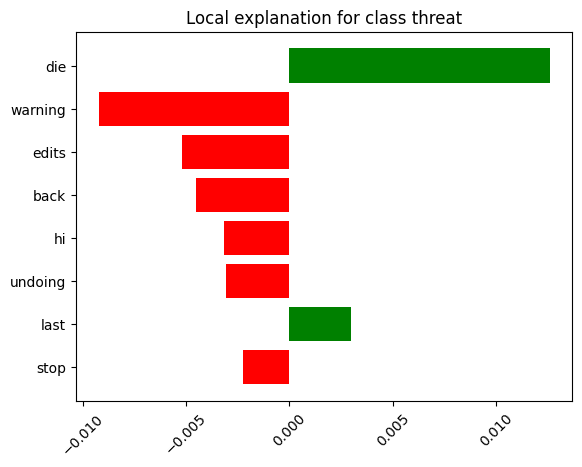

Comment: COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
Predicted flag for insult: 1
True flag for insult: 1


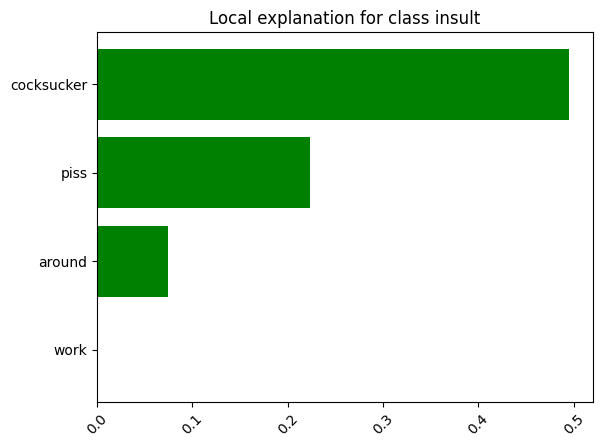

Comment: u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum poopie
Predicted flag for identity_hate: 1
True flag for identity_hate: 1


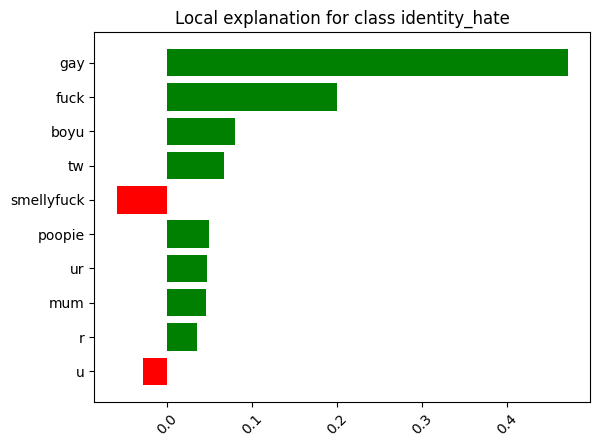

In [51]:
# get explanations for the independent model

# positive comment explained for non-toxic flag
comment_row = df[(df[labels.keys()] == 0).all(axis=1)].iloc[0]
comment = comment_row['processed_comment_text']
explanation = explainer.explain_instance(comment, independent_classifier, num_samples=100, labels=labels.values()) # get Explanation object
    
independent_preds = (independent_classifier([comment])[0] > 0.5).astype(int)

fig = explanation.as_pyplot_figure(label=labels['toxic'])
for tick in fig.get_axes()[0].get_xticklabels():
    tick.set_rotation(45)
print(f"Comment: {comment_row['comment_text']}")
print(f"Predicted flags: {independent_preds}")
print(f"True flags:\n{comment_row[labels.keys()]}")
plt.show()

# negative comments by labels
independent_indices = [0, 1, 3, 0, 0, 4] # individual indices for each label

for label in labels.keys():
    idx = independent_indices[labels[label]]
    comment_row = df[df[label] == 1].iloc[idx]
    comment = comment_row['processed_comment_text']
    explanation = explainer.explain_instance(comment, independent_classifier, num_samples=100, labels=labels.values()) # get Explanation object
    
    independent_preds = (independent_classifier([comment])[0] > 0.5).astype(int)

    fig = explanation.as_pyplot_figure(label=labels[label])
    for tick in fig.get_axes()[0].get_xticklabels():
        tick.set_rotation(45)
    print(f"Comment: {comment_row['comment_text']}")
    print(f"Predicted flag for {label}: {independent_preds[labels[label]]}")
    print(f"True flag for {label}: {comment_row[label]}")
    plt.show()